<center>

<h1> Fractional Cox-Ross-Rubenstein Option Pricing Model </h1>   
<h2> -- Python Experiments -- </h2>

<h4> Houssem Ben Romdhane </h4>

    
*****************
 

In this notebook, we run code snippets one at a time in order to visualize the different phenomena and generate the plots added in the thesis' report. The present file and can be found under https://github.com/houssem-br/fCRR. It is a complement to the thesis and some parts of it can only be well understood by reading the corresponding sections. Please start by running the following block to import all packages required for a proper code execution and to set the plotting parameters. It might be necessary to manually install some of these packages. If this is the case, please run this command line, where you replace &lt;package-name&gt; by the name of the missing package.
```
python -m pip install <package-name>
```

In [1]:
# import packages
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from scipy.special import gamma, beta, hyp2f1
from scipy import integrate
from scipy.interpolate import UnivariateSpline
from itertools import product


# set matplotlib parameters
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (14, 4)
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['figure.dpi'] = 80
plt.rcParams['lines.linewidth'] = 1

## 1. Fractional Brownian Motion
A Gaussian process $\left\{ W_t^H  \right\}_{t \in [0,T]}$, $T > 0$ with zero mean is called fractional Brownian motion with Hurst index (or self-similarity parameter) $H \in (0, 1)$ if for all $t,s \in [0, T]$
\begin{equation}\label{eq: cov fbm}
\operatorname{E}\left[W_t^H W_s^H\right] = \frac{1}{2} \left( |t|^{2H} + |s|^{2H} - |t-s|^{2H} \right).
\end{equation}

The main property that make fractional Brownian motion attractive for financial time series modeling are the long-range dependence of its increments. Long-range dependence means that the process has a long-term memory, i.e., the autocorrelation function is non-zero even at large lags. To better visualize this property, let $H \in (0, 1)$ and define the increments
\begin{equation*}
     \xi^H_n = W^H_{n} - W^H_{n-1} , \quad n= 1, 2, \dots    
\end{equation*}

Then, the covariance function $\gamma_\xi(n) = \operatorname{E}\left[\xi_1 \xi_{n+1} \right]$, $ n= 0, 1, 2, \dots$ is given by
\begin{align*}
\gamma_\xi(n) & = \operatorname{E}\left[ W^H_{1} \left(W^H_{n+1} - W^H_{n} \right) \right] \\
& = \frac{1}{2} \left( 1^{2^H} + (n+1)^{2H} - n^{2H} - 1^{2H} - n^{2H} + (n-1)^{2H} \right) \\
& = \frac{1}{2} \left( (n+1)^{2H} - 2n^{2H} + (n-1)^{2H} \right),
\end{align*}
where we made use of the fact that $W^H_0 = 0$ almost surely in the first equation.

An intuitive way to look at long-term memory consists in studying whether $ \sum_{n=1}^\infty \left|\gamma_\xi(n)\right| = +\infty$. This is clearly the case for $H \in (\frac{1}{2}, 1)$. The autocovariance as a function of the lag $n$ is illustrated in the figure below for various values of $H > \frac{1}{2}$.

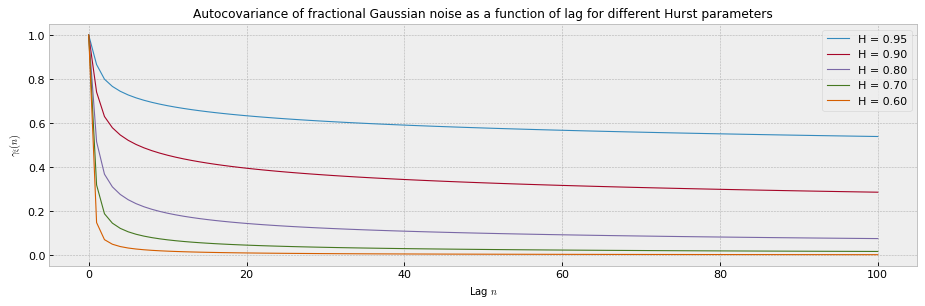

In [2]:
def gamma_xi(H, k):
    if k == 0:
        return 1
    return .5 * ((k+1)**(2*H) - 2*(k**(2*H)) + (k-1)**(2*H))

lags = range(101)
v_hs = [.95, .9, .8, .7, .6]
for H in v_hs:
    plt.plot(lags, [gamma_xi(H, k) for k in lags])
plt.legend([r'H = %.2f' % H for H in v_hs])
plt.title('Autocovariance of fractional Gaussian noise as a function of lag for different Hurst parameters')
plt.xlabel(r'Lag $n$')
plt.ylabel(r'$\gamma_\xi(n)$')
plt.show()

In their pioneering paper, Mandelbrot and van Ness defined fractional Brownian motion in a more constructive fashion. They constructed it as a moving average of standard Brownian motion over $\mathbb{R}$. The following representation is a slightly adjusted version. The adjustment is performed to get the standard fractional Brownian motion we defined. The original definition used a factor $\left( \Gamma\left(H+\frac{1}{2}\right)\right)^{-1}$, $\Gamma$ being the Gamma function $\Gamma(\alpha)=\int_{0}^{\infty} x^{\alpha-1} e^{-x} d x$.


Let $H \in (0,1)$. Consider the stochastic process $\left\{X_t \right\}_{t \in \mathbb{R}}$ defined by
\begin{equation*}
    X_t = \frac{1}{A_H}\int_{\mathbb{R}}\left[(t-u)_+^{H-\frac{1}{2}}-(-u)_+^{H-\frac{1}{2}}\right] d W_u, 
\end{equation*}
where $x_+ = \max (x, 0)$, and
\begin{equation*}
    A_H = \left( \int_\mathbb{R} \left\{ (1-u)_+^{H-\frac{1}{2}} - (-u)_+^{H-\frac{1}{2}} \right\}^2 d u \right)^{\frac{1}{2}}.
\end{equation*}
Then, $\left\{X_t \right\}_{t \geq 0}$ is a fractional Brownian motion.

This integral representation of fractional Brownian motion is not unique. Indeed many similar representations have been constructed to fit specific applications of fractional Brownian motion. One of the main drawbacks of the Mandelbrot-van Ness representation becomes apparent when attempting to simulate farctional Brownian motion. It requires a truncation of the integral to a finite range, which affects long-range dependence. The next integral representation is the so-called Molchan-Golosov representation. It helps overcome the truncation problem and will prove to be very useful in what follows. Since long-range dependence of increments occurs only for $\frac{1}{2}<H<1$, we restrict ourselves to this case. 


Let $H \in (\frac{1}{2}, 1)$. Consider the kernel
\begin{equation*}
k_H(t,u) = \left\{\begin{array}{ll}
    C_H u^{\frac{1}{2} - H} \int_{u}^{t} v^{H-\frac{1}{2}}(v-u)^{H-\frac{3}{2}} \,d v,  &  \text{ if } t > u \geq 0\\
     0, &  \text{ otherwise }
\end{array} \right.  
\end{equation*}
with
$$C_H = \left( \frac{H (2H -1)}{B\left(2-2H, H-\frac{1}{2}\right)}\right)^\frac{1}{2},$$
where $B$ denotes the beta function $B(\mu, \nu)=\int_{0}^{1} t^{\mu-1}(1-t)^{\nu-1} \,d t = \Gamma(\mu) \Gamma(\nu) \left(\Gamma(\mu+\nu)\right)^{-1}$. Then $X_t = \int_0^t k_H(t,u) \,d W_u$, for $t \geq 0$, is a fractional Brownian motion with Hurst index $H$.

## 2. Simulation of Fractional Brownian Motion

The aim of this section is to introduce discrete simulation methods of fractional Brownian motion. We distinguish between exact and approximation methods. Exact methods usually make use of some properties of the process, require computationally expensive operations, e.g., matrix inversion or decomposition, and scale poorly as the sample size increases. Approximation methods, however, can produce decently accurate results while drastically reducing computational complexity. Many exact and approximate methods have been developed to simulate stochastic processes in general, Gaussian processes or stationary Gaussian processes, all of which could be used to produce sample paths of fractional Brownian motion. The Hosking algorithm, spectral simulation, importance sampling, and wavelet-based simulation are but a few examples of methods that could be applied in our particular case, namely a stochastic representation method based on the Mandelbrot-van Ness integral representation of fractional Brownian motion, the Cholesky method, and the method of Davies and Harte.

### 2.1 Stochastic Representation Method

The stochastic representation method is the first and most natural simulation algorithm suggested to generate fractional Brownian motion (Coeurjolly 2000). It consists in discretizing the integral representation of fractional Brownian motion and approximate it by a Riemann sum. First, we know that for $t \in \mathbb{R}$,
\begin{align*}
    W_t^H &= \frac{1}{A_H} \int_\mathbb{R} \left[ (t-u)_+^{H-\frac{1}{2}} - (-u)_+^{H-\frac{1}{2}} \right] d W_u \\
    &= \frac{1}{A_H} \left( \int_{-\infty}^0 \left[ (t-u)^{H-\frac{1}{2}} - (-u)^{H-\frac{1}{2}} \right] d W_u + \int_0^t (t-u)^{H-\frac{1}{2}} d W_u \right).
\end{align*}
Now let $V_{1}$ and $V_{2}$ are vectors of independent and standard Gaussian random variables of size $b +1$ and $N$, respectively, for some $b \in \mathbb{N}$. The integral above can be approximated using a lower bound $b \to +\infty$. For $i \in \left\{0, 1, \dots, N-1\right\}$, we get
$$
\tilde{W}^H_{t_i} = \frac{1}{A_H N^{H}}\left\{\sum_{k=-b}^{0}\left[(i-k)^{H-\frac{1}{2}}-(-k)^{H-\frac{1}{2}}\right] V_{1,i}+\sum_{k=0}^{i}(i-k)^{H-\frac{1}{2}} V_{2,i}\right\}.
$$

This simulation method highly depends on the chosen value of $b$: A higher $b$ leads to a more precise generation of fractional Brownian motion but requires more computational power. A lower value leads to the opposite outcome: Fast execution that lacks the required precision. This algorithm is almost never used and is only relevant from a historical point of view. Various algorithms could be similarly derived from other stochastic representations of $\left\{W^H_t\right\}$.

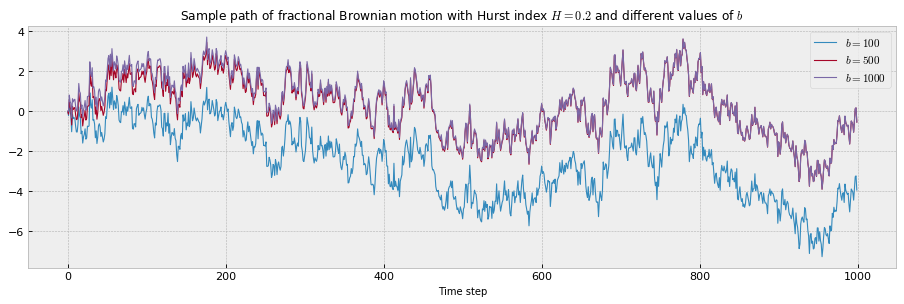

In [3]:
def fbm_stochrep(H, N, b=None):
    if b is None:
        b = int(N**1.5) + 1
    fbm = [0]    
    V2  = np.random.normal(size=N)
    V1  = np.random.normal(size=b+1)
    A_H = ((gamma(2*H+1) * np.sin(np.pi*H))**.5) / gamma(H+.5)
    for i in range(1, N):
        M1 = [(((i-k)**(H-.5)-(-k)**(H-.5)) * V1[k]) for k in range(-b, 1) if k != i and k != 0]
        M2 = [((i-k)**(H-.5) * V2[k]) for k in range(i+1) if k != i]
        fbm.append((sum(M1) + sum(M2))*(N**(-H))/A_H)  
    return fbm

seed  = np.random.randint(10**3)
N     = 10**3
H     = .2
v_b = [10**2, 5 * 10**2, 10**3]
for b in v_b:
    np.random.seed(749)
    plt.plot(fbm_stochrep(H, N, b)) 
plt.legend([r'$b = %d$' % b for b in v_b])
plt.title(r'Sample path of fractional Brownian motion with Hurst index $H = %.1f$ and different values of $b$' % H)
plt.xlabel('Time step')
plt.show()

### 2.2. The Cholesky Method

The Cholesky method is an algorithm used to generate samples of the random variables given their covariance function. It can be applied to generate Gaussian processes in general and does not require stationarity. Its algorithm makes mainly use of the Cholesky factorization to decompose a matrix into the product of a lower triangular matrix and its conjugate transpose.

Suppose we want to generate a fractional Brownian motion with sample size $N$ over the interval $[0, 1]$. We denote by $\Sigma$ its discretized covariance matrix at times $t_k = \frac{k}{N}$, $k = 0,1,\dots,N-1$. $\Sigma$ is then defined by
\begin{equation}\label{eq: sigma}
    \left( \Sigma \right)_{k,l} = \operatorname{E}\left[ W^H_{t_k} W^H_{t_l} \right] \quad, k,l= 0,1,\dots,N-1.
\end{equation}
Clearly, $\Sigma$ is symmetric and positive definite. Hence, there exists a unique lower triangular matrix $L \in \mathbb{R}^{N\times N}$ such that $\Sigma = L L^\intercal$. Now let $Z$ be a vector of $N$ independent identically distributed standard Gaussian variables. The vector $LZ$ is centered since all elements of $Z$ are zero-mean, and its covariance is
$$ \operatorname{E}\left[\left(L Z\right) \left(L Z\right)^\intercal \right] = \operatorname{E}\left[L Z Z^\intercal L^\intercal \right] = \operatorname{E}\left[Z Z^\intercal \right] \operatorname{E}\left[L L^\intercal \right] = \Sigma.$$
Since a Gaussian process is completely defined by its first and second moments, $LZ$ must be a realization of the fractional Brownian motion with Hurst index $H$. Note that using this method, it is also possible to generate samples of fractional Gaussian noise and compute their partial sums to get the desired realization of fractional Brownian motion.

The Cholesky method is one of the simplest algorithms one could use to generate sample paths of stochastic processes. It has, however, a complexity of $\mathcal{O}\left(n^3\right)$. Once the covariance matrix decomposed, the cost to generate new sample paths is reduced to $\mathcal{O}\left(n^2\right)$. For larger values of $N$, the algorithm would be very slow. Moreover, the covariance matrix $\Sigma$ is ill-conditioned. Therefore, several researchers attempted to adjust and improve the Cholesky method, which gave rise to an array of new algorithms (e.g., the Hosking method).

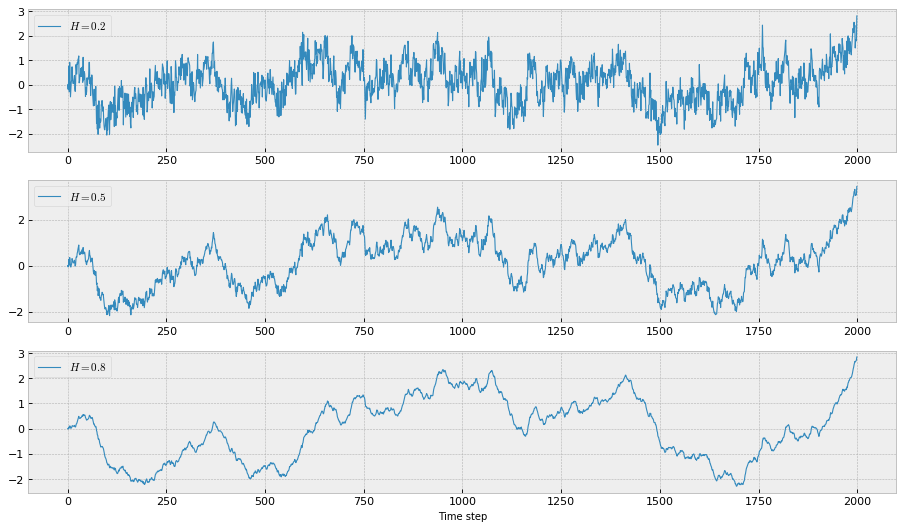

In [4]:
 def fbm_cholesky(H, N):
    cov = np.empty((N-1, N-1))
    for i in range(1,N):
        for j in range(i, N):
            sig = .5 * (i**(2*H) + j**(2*H) - abs(i-j)**(2*H)) * (N**(-H))
            cov[i-1,j-1] = sig
            cov[j-1,i-1] = sig
    L   = np.linalg.cholesky(cov)
    Z   = np.transpose(np.random.normal(loc=0.0, scale=1.0, size=N-1))
    fbm = list([0]) + list(np.matmul(L, Z))
    return fbm

seed    = np.random.randint(10**3)
N       = 2 * 10**3
indices = [.2, .5, .8]
fig     = plt.figure(figsize=(14, 8))
for i, H in enumerate(indices, 311):
    np.random.seed(438)
    ax  = fig.add_subplot(i)
    ax.plot(fbm_cholesky(H,N))
    ax.legend([r'$H = %.1f$' % H], loc=2)
ax.set_xlabel('Time step')
plt.show()

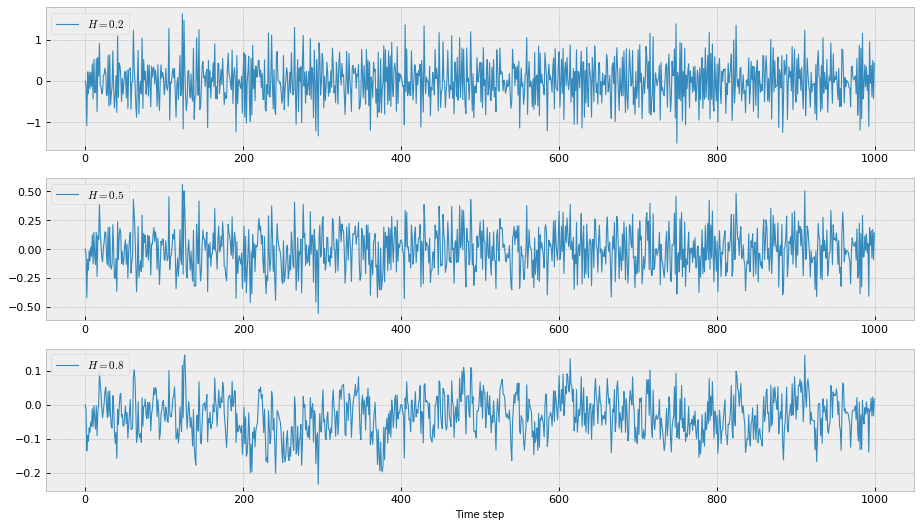

In [5]:
def fbm2fgn(fbm):
    return np.diff(fbm, prepend=0)

seed    = np.random.randint(10**3)
N       = 10**3
indices = [.2, .5, .8]
fig     = plt.figure(figsize=(14, 8))
for i, H in enumerate(indices, 311):
    np.random.seed(seed)
    ax  = fig.add_subplot(i)
    ax.plot(fbm2fgn(fbm_cholesky(H,N)))
    ax.legend([r'$H = %.1f$' % H], loc=2)
ax.set_xlabel('Time step')
plt.show()

### 2.3 The Method of Davies and Harte

The method of Davies and Harte is another, more advanced method to generate  sample paths of stationary Gaussian processes and can therefore be used to generate fractional Gaussian noise. In this section, we will solely present a generalized version of the algorithm by Wood and Chan. Our goal is to generate a realization with sample size $N \in \mathbb{N}$, i.e., produce values at times $t_k = \frac{k}{N}$ for $k=1, \dots, N-1$. We can either directly simulate the process, or generate a sample of fractional Gaussian noise (which has the advantage of being stationary) and compute the partial sums thereof. In the second case, we define the increments $\xi^H_1 = W^H_{t_1}$ and $\xi^H_k = W^H_{t_{k}} - W^H_{t_{k-1}}$ for $k= 2, 3, \dots, N-1$. These random variables are standard normal with covariance 
\begin{align*}
\operatorname{E}\left[\xi^H_1 \xi^H_{k+1}\right] & = \operatorname{E}\left[ W^H_{t_1} \left(W^H_{t_{k}} - W^H_{t_{k-1}} \right) \right] \\
& = \frac{1}{2 N^H} \left( 1^{2^H} + (k+1)^{2H} - k^{2H} - 1^{2H} - k^{2H} + (k-1)^{2H} \right) \\
& = \frac{1}{2 N^H} \left( (k+1)^{2H} - 2k^{2H} + (k-1)^{2H} \right).
\end{align*}
Once we generate samples $\tilde{\xi}^H_{t_1}, \tilde{\xi}^H_{t_2}, \dots, \tilde{\xi}^H_{t_N}$of the increments, we compute the partial sums $\tilde{W}^H_{t_k} = \sum_{l=1}^{k} \tilde{\xi}^H_{t_l}$ for $k= 1, 2, \dots, N-1$ to obtain a sample path $0, \tilde{W}^H_{t_1}, \tilde{W}^H_{t_2}, \dots, \tilde{W}^H_{t_{N-1}}$ of fractional Brownian motion.


The method of Davies and Harte produces samples of increments, which then can be used to generate fractional Brownian motion. It attempts to determine a matrix $G$ such that $\Sigma_{\xi^H} = G G^*$, where $\Sigma_{\xi^H}$ is the covariance matrix of the increments satisfying $\left(\Sigma_{\xi^H}\right)_{k,l} = \gamma_\xi \left(\frac{|k-l|}{N}\right) =: \gamma(|k-l|)$ for $k,l = 0, 1, \dots, N-1$. The main idea behind this method is to embed $\Sigma_{\xi^H}$ in a circulant matrix $\mathcal{C} \in \mathbb{R}^{m \times m}$, i.e., a matrix of the form
\begin{equation*}
\mathcal{C}=\left(\begin{array}{ccccc}
c_{0} & c_{1} & \cdots & c_{m-2} & c_{m-1} \\
c_{m-1} & c_{0} & c_{1} & \cdots & c_{m-2} \\
c_{m-2} & c_{m-1} & c_{0} & \cdots & c_{m-3} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
c_{1} & c_{2} & c_{3} & \cdots & c_{0}
\end{array}\right), \; \text{ where } c_{k}=\left\{\def\arraystretch{1.4}\begin{array}{ll}
\gamma\left(k\right) & \text { if }  0 \leq k<\frac{m}{2} \\
\gamma\left({m-k}\right) & \text { if }  \frac{m}{2}\leq k \leq m-1
\end{array}\right. ,
\end{equation*}
where $m = 2(N-1)$. The algorithm makes uses of a fast Fourier program. To reduce the number of operations and improve performance, the size of the matrix has to be a power of $2$, which means that it would be much faster to choose $m = 2^g$ for some $g \in \mathbb{N}$. Suppose we want to simulate $N^\prime$ values of fractional Gaussian noise. In order to embed the covariance matrix in a circulant matrix, $g$ has to be the smallest natural number satisfying $2^g \geq 2(N^\prime-1)$, i.e., $g=\lceil \log (2(N^\prime -1)) (\log 2)^-1\rceil$. To ensure the best performance possible, the number of samples generated needs to be increased to $N = 2^{g-1} + 1$.
 
The covariance structure of the desired stationary process is thereby embedded into the upper left corner of the matrix. More precisely, the circulant matrix reads
$$
\mathcal{C}=\left(\def\arraystretch{1.2}\begin{array}{cccccc}
\gamma(0) &  \cdots & \gamma({N-1})  & \gamma({N-2}) & \cdots & \gamma({1}) \\
\gamma({1}) &  \cdots & \gamma({N-2})  & \gamma({N-1}) & \cdots & \gamma(2) \\
\vdots  & \ddots & \vdots  & \vdots & \ddots & \vdots \\
\gamma({N-1}) & \cdots & \gamma(0)  & \gamma({1}) & \cdots & \gamma({N-2}) \\ 
\gamma({N-2}) &  \cdots & \gamma({1}) &  \gamma(0) & \cdots &\gamma({N-3}) \\
\vdots &  \ddots & \vdots &  \vdots & \ddots & \vdots \\
\gamma({1}) &  \cdots & \gamma({N-2})  & \gamma({N-3}) & \cdots & \gamma(0)
\end{array}\right).
$$

An important property of the circulant matrix $\mathcal{C}$ is that it can be decomposed as $\mathcal{C} = Q \Lambda {Q}^*$ where $\Lambda = \operatorname{diag}\left( \lambda_1, \lambda_2, \dots, \lambda_m\right)$ is the diagonal matrix of (real) eigenvalues of $\mathcal{C}$ and $Q$ is a unitary matrix defined by
$$
(Q)_{k, l}=m^{-\frac{1}{2}} \exp \left\{ i \pi \frac{2 k l}{m}\right\}, \quad \text { for } k, l=0, \dots, m-1.
$$
Now let $G = Q \Lambda^\frac{1}{2} Q^*$. Since $Q$ is unitary, 
$G G^* = Q \Lambda^\frac{1}{2} Q^* Q \Lambda^\frac{1}{2} Q^* = Q \Lambda Q^* = \mathcal{C}$. Let $Z$ be a vector of $m$ independent standard normal variables and define $Y = G Z$. $Y$ is clearly centered and Gaussian. Moreover,  
$$ \operatorname{E}\left[Y Y^\intercal \right] = \operatorname{E}\left[G Z Z^\intercal G^\intercal \right] = \operatorname{E}\left[Z Z^\intercal \right] \operatorname{E}\left[G G^\intercal \right] = \mathcal{C}.$$
Hence, $Y$ a multivariate Gaussian with covariance matrix $\mathcal{C}$ and the vector of fractional Gaussian noise we wish to generate has the same distribution as the sequence $\{Y_j\}_{j=0 }^{j=N-1}$. The increments can be computed by taking the corresponding fast Fourier Transform 
$$\xi^H_{t_k} = m^{-\frac{1}{2}} \sum_{l=0}^{m-1} \sqrt{\lambda_l} \left(Q^* Z \right)_l \exp\left\{i \pi \frac{2kl}{m}\right\}, \quad \text{ for } k=1, 2, \dots, N$$
The generated values are real by construction. The sample path of the desired fractional Brownian motion can be generated by setting the first value to zero and computing the partial sums $\sum_{l=1}^{k} \xi^H_{t_l}$ for $k = 1,2, \dots, N-1$ of the fractional Gaussian noise. This algorithm has a computational complexity of $\mathcal{O}\left(N \log N\right)$. The following algorithm is in part based on the description in Coeurjolly 2000.

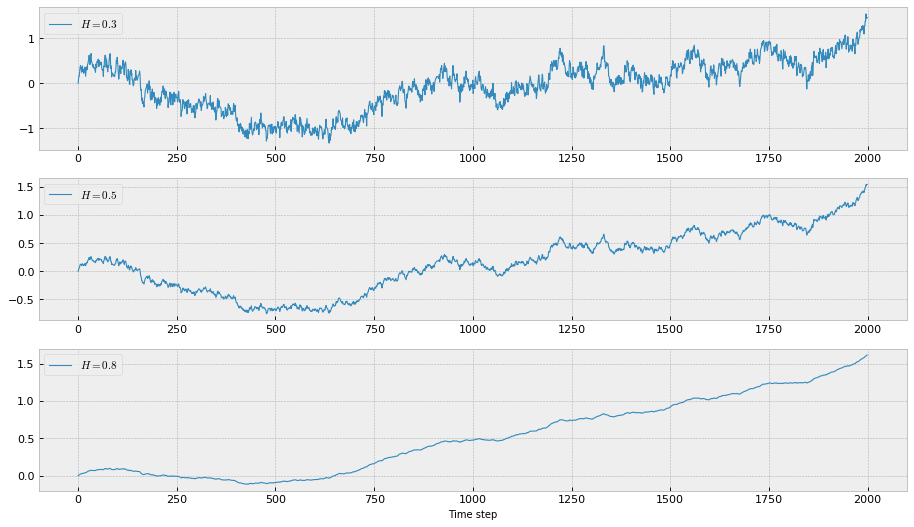

In [6]:
def fgn2fbm(fgn):
    return np.cumsum(fgn)

def gamma_xi(H, N, k):
    return 0.5*(np.abs(k-1)**(2*H) - 2*(np.abs(k)**(2*H)) + np.abs(k+1)**(2*H)) * (N**(-2*H))

def fbm_daviesharte(H, N):
    m = 2**(int(np.log(2*(N-1))/np.log(2)))
    c = [gamma_xi(H, N, min(m-k,k)) for k in range(0,m)]
    lambdas = np.fft.fft(c)

    W = np.zeros(m, dtype=np.complex) 
    W[0] = np.random.standard_normal()
    W[int(m/2)] = np.random.standard_normal()

    for j in range(1,int(m/2)):
        uj, vj = np.random.standard_normal(), np.random.standard_normal() 
        W[j] = 2**(-.5) * complex(uj, vj)
        W[m-j] = 2**(-.5) * complex(uj, -vj)

    X = m**(-.5) * np.fft.fft( lambdas**.5 * W).real
    return(np.insert(X[:N-1], 0, 0, axis=0))

seed    = np.random.randint(10**3)
N       = 2*10**3
indices = [.3, .5, .8]
fig     = plt.figure(figsize=(14, 8))
for i, H in enumerate(indices, 311):
    np.random.seed(1)
    ax  = fig.add_subplot(i)
    ax.plot(fgn2fbm(fbm_daviesharte(H,N)))
    ax.legend([r'$H = %.1f$' % H], loc=2)
ax.set_xlabel('Time step')
plt.show()

### 2.4 Performance Analysis

A comparative test of the performance of all three methods confirms the theoretical computational complexity. Despite generating more samples than needed, the Davies and Harte method is the fastest ($\sim$ 10 ms/loop), followed by the Cholesky method ($\sim$ 650 ms/loop), with the stochastic representation method way behind with an average of 22000 ms/loop.

In [7]:
H = .75
N = 10**3

for f in [fbm_stochrep, fbm_cholesky, fbm_daviesharte]:
    print('\n%s: ' %f.__name__)
    %timeit f(H, N)


fbm_stochrep: 
22.1 s ± 638 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

fbm_cholesky: 
648 ms ± 23.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

fbm_daviesharte: 
10.5 ms ± 631 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## 3. Long-Range Dependence in Financial Data
Stylized facts are universal statistical properties that time series of financial assets have, regardless of the instrument's nature or where it is being traded. They are empirical regularities observed in most stocks, derivatives (including options), and foreign exchange rates across different markets whether in New York, Frankfurt, or Shanghai. There is no unanimously accepted precise definition of stylized facts. As a consequence, no exhaustive list of these features exists. Long-range dependence has long been presented as a stylized fact, or statistical irregularity, of financial markets.

### 3.1 Observations of Financial Markets
 
Indeed, historical records of financial data usually display non-periodic cyclical patterns which, according to many researchers indicates the presence of significant power at low frequencies, i.e., long-range dependence. The figure below depicts the log-returns of Microsoft since its initial public offering in March 1986 and the approximate autocorrelation (up to a lag of 300 days) of some of the most traded financial assets. The log-returns display a clustering of volatility, which hints at a possible persistent behavior of price increments. Moreover, all autocorrelation functions seem to decrease rather slowly. Whether this behavior corresponds to long-range dependence is still an ongoing debate. Besides, these claims have arguably not been substantiated by statistical analyses of the time series. 

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


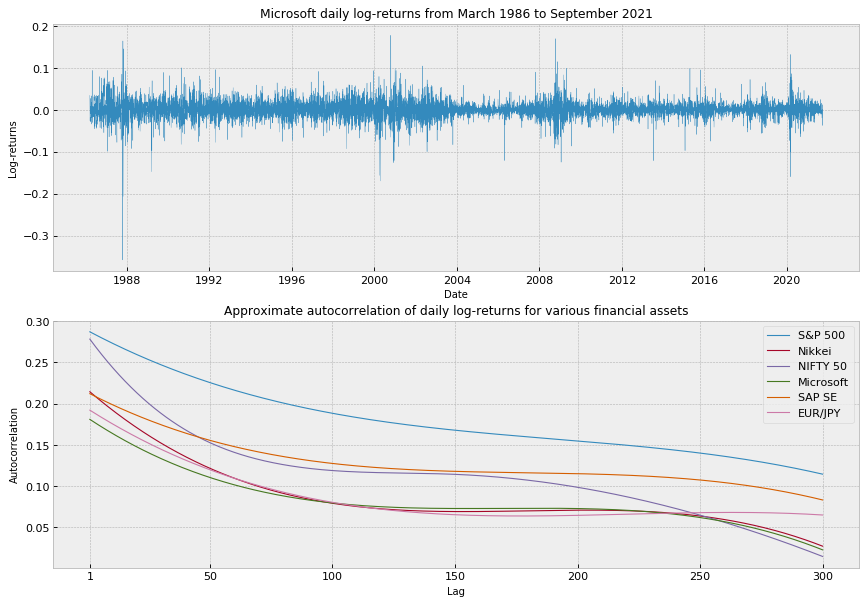

In [8]:
def log_returns(stock, interval, period):
    price = yf.download(stock, period=period, interval=interval);
    returns = np.diff(np.log(price['Adj Close']))
    dates = [dt.datetime.strptime(str(i)[:19],'%Y-%m-%d %H:%M:%S') for i in price.index[:-1]]
    return dates, returns

def autocorr(x, maxlags):
    corr =np.correlate(x - x.mean(),x - x.mean(),'full')[len(x)-1:] / (np.var(x) * len(x))
    return corr[1:min(len(corr),maxlags)]


dates, returns_msft = log_returns('MSFT', '1d', 'max')
series  = {'^GSPC':'S&P 500', '^N225':'Nikkei', '^NSEI':'NIFTY 50', 'MSFT': 'Microsoft', 'SAP': 'SAP SE', 'EURJPY=x':'EUR/JPY'}
returns = {}
lags    = range(1,301)
for serie in series:
    _, returns[serie] = log_returns(serie, '1d', 'max')
plt.figure(figsize=(13,9))
plt.subplot(211)
plt.plot(dates, returns_msft, linewidth=.3)
plt.title('Microsoft daily log-returns from March 1986 to September 2021')
plt.xlabel('Date')
plt.ylabel(r'Log-returns')
plt.subplot(212)
series = {'^GSPC':'S&P 500', '^N225':'Nikkei', '^NSEI':'NIFTY 50', 'MSFT': 'Microsoft', 'SAP': 'SAP SE', 'EURJPY=x':'EUR/JPY'}
lags = range(1,301)
for serie in series:
    acf        = autocorr(np.abs(returns[serie]), max(lags)+1)
    spline     = UnivariateSpline(lags, acf, s=.1)
    lags_      = np.linspace(min(lags), max(lags), 500)
    acf_       = spline(lags_)
    plt.plot(lags_, acf_, label=series[serie], linewidth=1)
plt.title('Approximate autocorrelation of daily log-returns for various financial assets')
plt.xlabel('Lag')
plt.xticks([1] + [50 * k for k in range(1, int(max(lags)/50)+1)])
plt.ylabel('Autocorrelation')
plt.legend()
plt.show()

### 3.2. R/S Analysis
From a historical standpoint, Mandelbrot was the first to investigate the presence of long-range dependence in stock returns. He conducted his empirical studies using the $R/S$-statistic, introduced by Hurst a few years before, and concluded that representative values of the self-similarity parameter of returns fluctuate around $H=0.55$. 

For a given sequence of observation $X_1, X_2, X_3, \dots$ with partial sums $Y_n = \sum_{k=1}^n X_k$, $n \in \mathbb{N^*}$, and sample variance $S_n^2 := n^{-1} \sum_{k=1}^n (X_k - n^{-1} Y_n)^2$, the $R/S$-statistic, short for rescaled adjusted range statistic, is defined by
\begin{equation}\label{eq: r/s statistic}
    \left(R/S\right)_n := \frac{1}{S_n} \left[ \max_{0\leq k \leq n} \left( Y_k - \frac{k}{n} Y_n \right) - \min_{0\leq k \leq n} \left( Y_k - \frac{k}{n} Y_n \right) \right].
\end{equation}
Suppose we have a financial time series composed of $N$ observations. The $R/S$-analysis starts by dividing the data into $M$ disjoint subsets of length $n$ such such that $N=nM$. After computing all sample means and sample variances, the $R/S$-statistic can then be calculated for all subsets separately. Finally, the rescaled range value $(R/S)_n$ for the length $n$ is determined by averaging the individual rescaled ranges. The subset size $n$ is then increased to the next possible value. Hurst discovered that the $R/S$-statistic scales as a power law according to the formula $(R/S)_n \propto n^H$ as $n$ increases. An estimation $\hat{H}$ of the Hurst index can therefore be determined by running a linear regression using the equation
\begin{equation*}
    \log\left((R/S)_n\right) = \log(c) + \hat{H} \log(n).
\end{equation*}
The table below shows the measured Hurst index for various financial assets and scales. A typical value revolves around $0.55$, in line with Mandelbrot's observations more than half a century ago. In particular, no pattern can be discerned with regards to the scale (i.e., whether daily, weekly, monthly, or quarterly measurements yield the highest long-range dependence. It is nonetheless true that scales between one week and one month usually result in a higher value for the measured parameter. The following algorithm was written partly based on Voss 2000.

In [10]:
def abs_returns(stock, interval, period):
    price = yf.download(stock, period=period, interval=interval);
    returns = np.diff(price['Adj Close'])
    return returns

def hurst_index(data):
    k  = len(data)
    n  = 1
    RS = {}
    while k > 10:
        data_k  = [data[idx*k:(idx+1)*k] - np.mean(data[idx*k:(idx+1)*k])  for idx in range(n)]
        cum_dev = [np.cumsum(d) for d in data_k]
        RS[k]   = np.mean([(np.max(cum_dev[idx]) - np.min(cum_dev[idx])) / np.std(data_k[idx]) for idx in range(n)]) 
        k       = int(k/2)
        n      *= 2
    return np.polyfit(np.log(list(RS.keys())), np.log(list(RS.values())), 1)[0]

            
series = {'^GSPC':'S&P 500', '^GDAXI': 'DAX', '^N225':'Nikkei', 'EURJPY=x':'EUR/JPY', 'BTC-USD': 'BTC/USD', 'GBPUSD=X': 'GBP/USD', 'BZ=F': 'Brent', 'ZW=F': 'Wheat', 'SI=F': 'Silver'}
freq   = {'daily': '1d', 'weekly': '5d', 'monthly': '1mo', 'quarterly': '3mo'}
df     = pd.DataFrame(columns=freq.keys())
for f in freq:
    for stock in series:
        returns = abs_returns(stock, freq[f], 'max')
        df.loc[series[stock], f] = hurst_index(returns)     
print(df)           

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

## 4. Fractional Cox-Ross-Rubinstein Model

For $N > 1$, we consider the $N$-period fractional Cox-Ross-Rubinstein market composed of a bond and a stock traded at times $t_k = \frac{k}{N}$ for $k=0, 1, \dots, N$
\begin{align}
    B_k^{(N)} &= (1 + r_k^{(N)}) B_{k-1}^{(N)} \label{eq: bond fcrr} \\
    S_k^{(H,N)} &= \left(1 + a_k^{(N)} + \sigma I_k^{(H,N)} \right) S_{k-1}^{(H,N)}, \label{eq: stock fcrr}
\end{align}
where $\{I_k^{(H,N)}\}$ are the one-step increments of a "disturbed" random walk that is assumed to converge to fractional Brownian motion with Hurst index $H$. The definition of $\{I_k^{(H,N)}\}$ and the convergence of its cumulative sum to $\{W^H_t\}$ will be treated in the next section. The values $B_k^{(N)}$ and $S_k^{(H,N)}$ are held constant over the intervals $[t_k, t_{k+1})$ for all $k = 0,1, \dots, N-1$. The initial stock and bond prices are given by $B_0^{(N)} = 1$ and $S_0^{(H, N)}= S_0$, respectively. $r_k^{(N)}$, $a_k^{(N)}$, and $\sigma$ are the interest rate, the stock's drift, and its volatility, respectively. 

### 4.1. Approximation of Fractional Brownian Motion

For $N\in \mathbb{N}$, let $\{\xi_k^{(N)}\}_{k \in \mathbb{N}}$ be independent identically distributed Bernoulli random variables with $\operatorname{P}(\xi_k^{(N)} = 1 ) = \operatorname{P}(\xi_k^{(N)} = -1 ) = \frac{1}{2}$. These variables have mean zero and finite variance. Set
$$X_t^{(N)} = \sqrt{N}^{-1} \sum_{k=1}^{\lfloor n t \rfloor} \xi_k^{(N)}.$$
Donsker's theorem implies that the random walk process $X^{(N)}$ converges in distribution to the standard Brownian motion as $N \to \infty$ in the Skorokhod space, the space of càdlàg functions. Indeed, the figure below depicts the resulting binary tree, in which the nodes are equidistant at each time step.

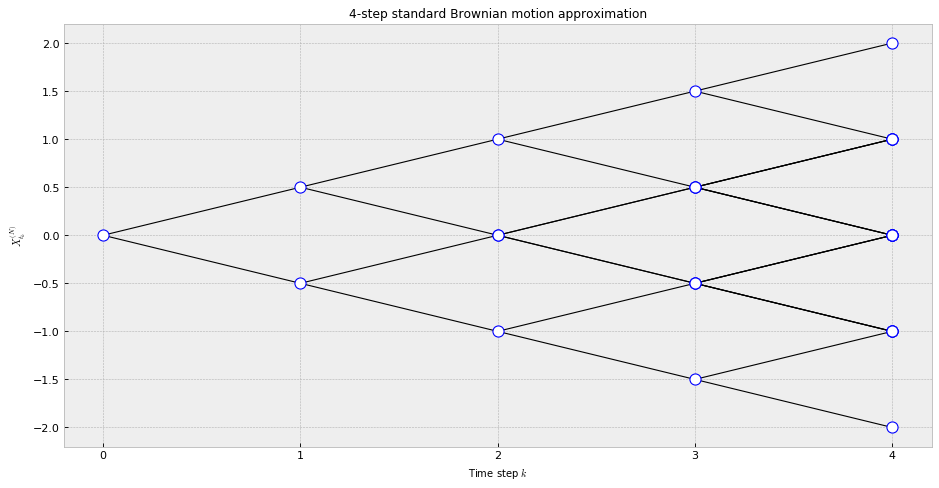

In [11]:
# case H = 0.5: Standard Brownian motion
N = 4
x_prev = [0]
segs   = []
for i in range(0,N):
    x_temp = []
    for x in x_prev:
        x_u = x + N**-.5
        x_d = x - N**-.5
        segs.extend([[[i, x], [(i+1), x_u]], [[i, x], [(i+1), x_d]]])
        x_temp.extend([x_u, x_d])
    x_prev = x_temp

_, ax = plt.subplots(figsize=(14,7))
ax.add_collection(LineCollection(segs, linewidths=1, colors='k', linestyle='solid'))
ax.plot(0, 0, 'bo', ms=10, mfc='w')
for seg in segs:
    ax.plot(seg[1][0], seg[1][1], 'bo', ms=10, mfc='w')
ax.set_title('%d-step standard Brownian motion approximation' % N)
ax.set_xlabel(r'Time step $k$')
ax.set_ylabel(r'$X^{(N)}_{t_k}$')
ax.set_xticks(range(N+1))
plt.show()

In order to define a fractional version of the process $X_t$ defined above, Sottinen's idea was to proceed in a similar fashion by defining a "disturbed'' random walk using the same kernel
$$k_H(t,s) = C_H s^{\frac{1}{2} - H} \int_{s}^{t} u^{H-\frac{1}{2}}(u-s)^{H-\frac{3}{2}} d u$$
that transforms the standard Brownian motion to fractional Brownian motion for $\frac{1}{2} < H < 1$. To this end, we introduce
$$k_H^{(N)}(t,s) := N \int_{s-\frac{1}{N}}^s k_H\left(\frac{\lfloor N t \rfloor}{N}, u\right) du$$
as an approximation of the Molchan-Golosov kernel and define
\begin{equation}\label{eq: apprx fbm}
    X_t^{(H, N)} := \int_0^t k_H^{(N)}(t,s) d W_s^{(N)} = \sum_{k=1}^{\lfloor N t\rfloor} \sqrt{N} \xi_{k}^{(N)} \int_{\frac{k-1}{N}}^{\frac{k}{N}} k_H\left(\frac{\lfloor N t\rfloor}{N}, s\right) \,d s .
\end{equation}

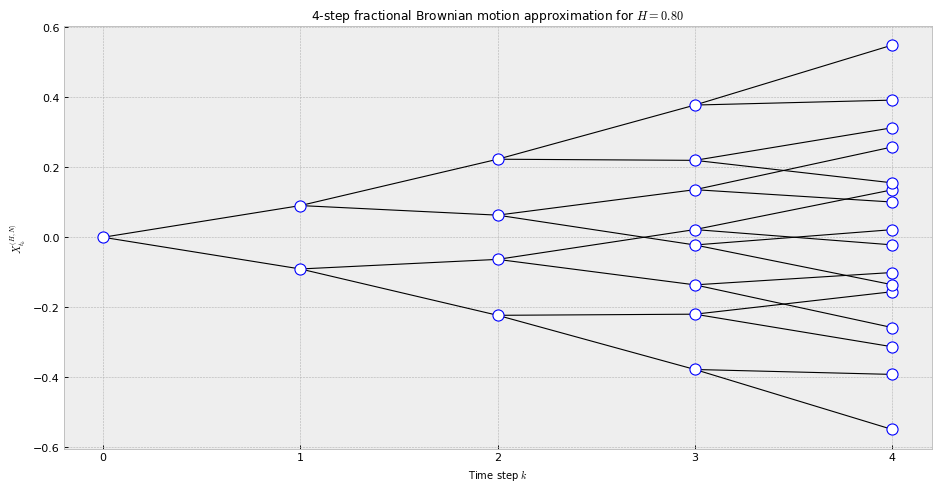

In [6]:
# case 0.5 < H < 1

def plot_tree(N, H, coefs, title):
    nodes  = {}
    segs   = []
    for i in range(N, 0, -1):
        for path in product([-1,1], repeat=i):
            nodes[path] = sum([coefs[i][k] * path[k] for k in range(i)])
    for i in range(N, 1, -1):
        for path in product([-1,1], repeat=i):
            segs.append([[i-1, nodes[path[:-1]]], [i, nodes[path]]])
    for path in product([-1,1], repeat=1):
        segs.append([[0, 0], [1, nodes[path]]])

    _, ax = plt.subplots(figsize=(14,7))
    ax.add_collection(LineCollection(segs, linewidths=1, colors='k', linestyle='solid'))
    ax.plot(0, 0, 'bo', ms=10, mfc='w')
    for seg in segs:
        ax.plot(seg[1][0], seg[1][1], 'bo', ms=10, mfc='w')
    ax.set_title(title)
    ax.set_xlabel(r'Time step $k$')
    ax.set_ylabel(r'$X^{(H,N)}_{t_k}$')
    ax.set_xticks(range(N+1))
    plt.show()

N   = 4
H   = .8
C_H = (H - .5) * (2 * H * gamma(1.5-H) / (gamma(H+.5) * gamma(2-2*H)))**.5

coefs = {}
for j in range(1,N+1):
    coefs[j] = []
    for k in range(1, j+1):
        t = j/N
        f = lambda s: ((t-s)**(H-.5)) * hyp2f1(.5-H, H-.5, H+.5, 1-(t/s))
        coefs[j].append(C_H * (N**.5) * integrate.quad(f, (k-1)/N, k/N)[0])

title = r'%d-step fractional Brownian motion approximation for $H = %.2f$' % (N, H)
plot_tree(N, H, coefs, title)

When the Hurst index index is smaller than $\frac{1}{2}$ the kernel we used above is no longer valid. Instead, we use the slightly more complicated kernel
\begin{equation}
    k_H(t,u) = c_{H}\left\{\left(\frac{t}{u}\right)^{H-\frac{1}{2}}(t-u)^{H-\frac{1}{2}}-\left(H-\frac{1}{2}\right) u^{\frac{1}{2}-H} \int_{u}^{t} v^{H-\frac{3}{2}}(v-s)^{H-\frac{1}{2}} \,d v\right\}
\end{equation}
if $t > u \geq 0$ and $0$ otherwise, with
\begin{equation*}
    c_H = \left( \frac{2H\Gamma\left(\frac{3}{2}-H\right)}{\Gamma\left(H+\frac{1}{2}\right) \Gamma\left(2-2H\right)} \right)^{\frac{1}{2}}.
\end{equation*}


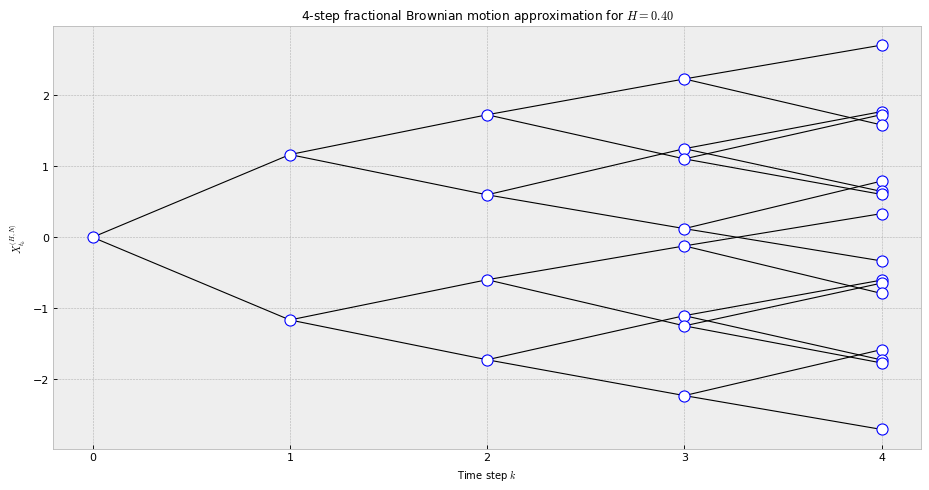

In [13]:
# case 0 < H < 0.5
N   = 4
H   = .4
c_H = (2 * H * gamma(1.5-H) / (gamma(H+.5) * gamma(2-2*H)))**.5

coefs = {}
for j in range(1,N+1):
    coefs[j] = []
    for k in range(1, j+1):
        t = j/N 
        f_1 = lambda s: ((t/s)**(H-.5)) * ((t-s)**(H-.5)) 
        f_2 = lambda u, s: (s**(.5-H)) * (u**(H-1.5)) * ((u-s)**(H-.5))
        coefs[j].append(c_H * (N**.5) * ((integrate.quad(f_1, (k-1)/N, k/N)[0] - (H-.5) * integrate.dblquad(f_2, (k-1)/N, k/N, lambda s: s, lambda s: t)[0])))

title = r'%d-step fractional Brownian motion approximation for $H = %.2f$' % (N, H)
plot_tree(N, H, coefs, title)

### 4.2. Arbitrage Opportunities

The fractional Cox-Ross-Rubinstein model admits arbitrage opportunities. Indeed, the picture below depicts an example of arbitrage in the $3$-period fractional Cox-Ross-Rubinstein model without drift (i.e. $a^{(3)}=0$). If we place ourselves at the second period after the price decreased twice, short the stock and lend the proceeds, we are guaranteed risk-free profits if we close our positions in the beginning of the next period. 

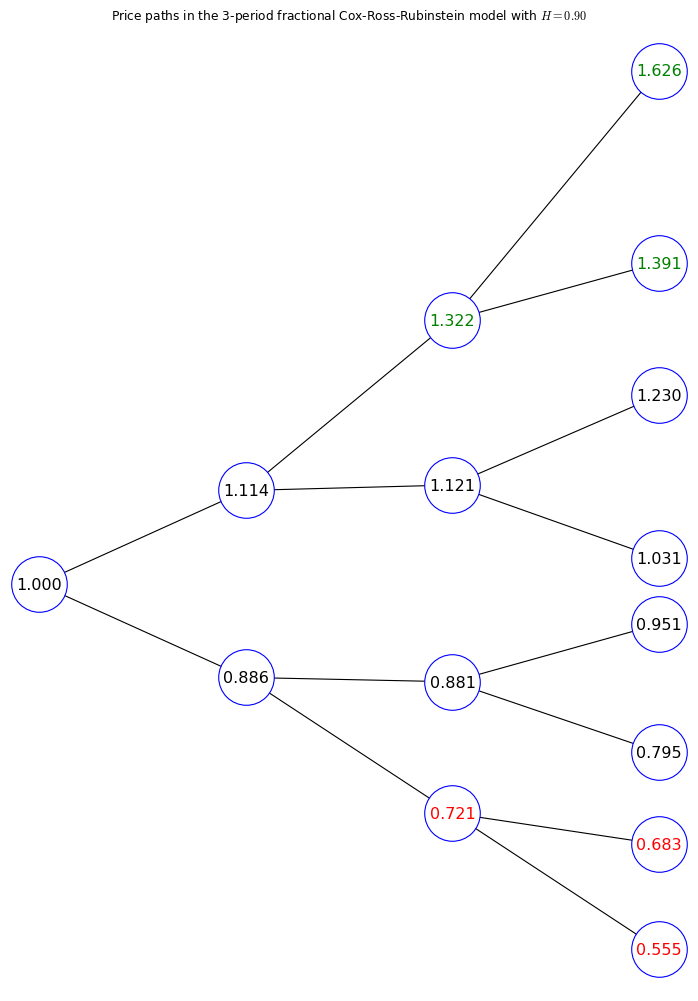

In [14]:
N   = 3
H   = .9
C_H = (H - .5) * (2 * H * gamma(1.5-H) / (gamma(H+.5) * gamma(2-2*H)))**.5

coefs = {0:[0]}
for j in range(1,N+1):
    coefs[j] = []
    for k in range(1, j+1):
        t = j/N
        f = lambda s: ((t-s)**(H-.5)) * hyp2f1(.5-H, H-.5, H+.5, 1-(t/s))
        coefs[j].append(C_H * (N**.5) * integrate.quad(f, (k-1)/N, k/N)[0])

nodes  = {(): 0}
S_0    = 1
prices = {():S_0}
segs   = []
for i in range(N, 0, -1):
    for path in product([-1,1], repeat=i):
        nodes[path] = sum([coefs[i][k] * path[k] for k in range(i)])       
for i in range(0, N):
    for path in product([-1,1], repeat=i):
        prices[path + (1,)]  = (1 +  nodes[path+ (1,)] - nodes[path]) * prices[path]
        prices[path + (-1,)] = (1 + nodes[path+ (-1,)] - nodes[path]) * prices[path]
for i in range(N, 1, -1):
    for path in product([-1,1], repeat=i):
        segs.append([[i-1, prices[path[:-1]]], [i, prices[path]]])
for path in product([-1,1], repeat=1):
    segs.append([[0, S_0], [1, prices[path]]])
_, ax = plt.subplots(figsize=(11,16))
ax.add_collection(LineCollection(segs, linewidths=1, colors='k', linestyle='solid'))
ax.plot(0, S_0, 'bo', ms=50, mfc='w')
ax.annotate('%.3f' % S_0, (0-.11, S_0-.007), size='x-large')
for seg in segs:
    x, y = seg[1][0], seg[1][1]
    color = 'k'
    if y > 1.3: color = 'g'
    if y < .75: color = 'r'   
    ax.plot(x, y, 'bo', ms=50, mfc='w')
    ax.annotate('%.3f' % y, (x-.11, y-.007), size='x-large', color=color)
ax.set_title(r'Price paths in the %d-period fractional Cox-Ross-Rubinstein model with $H = %.2f$' % (N, H))
plt.axis('off')
plt.show()

## References

- Coeurjolly 2000: Jean-Fran ̧cois Coeurjolly, "Simulation and Identification of the Fractional Brownian
Motion: A Bibliographical and Comparative Study". In: Journal of Statistical
Software 5.7 (2000). doi: 10.18637/jss.v005.i07.
- Voss 2013: Jason Voss, "Rescaled Range Analysis: A Method for Detecting Persistence, Randomness, or Mean Reversion in Financial Markets", CFA Institute (2013). url: https://blogs.cfainstitute.org/investor/2013/01/30/rescaled-range-analysis-a-method-for-detecting-persistence-randomness-or-mean-reversion-in-financial-markets/